Install and import necessary initial libraries

In [5]:
!pip install pyspark 

  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=85fe2ea121499054fe625fb6cab56a8edca9930b7b5fef17401d836622af2eb5
  Stored in directory: c:\users\tfls_\appdata\local\pip\cache\wheels\9f\f5\07\7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [14]:
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

Create the pyspark session & preprocessing the data

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sentiment').getOrCreate()

In [3]:
#read the data
data = spark.read.csv(r'C:\Users\tfls_\Documents\GitHub\bigdata\DisneylandReviews.csv',inferSchema=True,header=True)

In [4]:
data.show()

+---------+------+----------+--------------------+--------------------+-------------------+
|Review_ID|Rating|Year_Month|   Reviewer_Location|         Review_Text|             Branch|
+---------+------+----------+--------------------+--------------------+-------------------+
|670772142|     4|    2019-4|           Australia|If you've ever be...|Disneyland_HongKong|
|670682799|     4|    2019-5|         Philippines|Its been a while ...|Disneyland_HongKong|
|670623270|     4|    2019-4|United Arab Emirates|Thanks God it was...|Disneyland_HongKong|
|670607911|     4|    2019-4|           Australia|HK Disneyland is ...|Disneyland_HongKong|
|670607296|     4|    2019-4|      United Kingdom|the location is n...|Disneyland_HongKong|
|670591897|     3|    2019-4|           Singapore|Have been to Disn...|Disneyland_HongKong|
|670585330|     5|    2019-4|               India|Great place! Your...|Disneyland_HongKong|
|670574142|     3|    2019-3|            Malaysia|Think of it as an...|Disneylan

In [5]:
#import necessary pipeline functions
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer, NGram, MinHashLSH, HashingTF
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F

In [6]:
tokenizer = RegexTokenizer(inputCol="Review_Text", outputCol="lowercase")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="removed")
pipeline1 = Pipeline(stages=[tokenizer,remover])

In [7]:
#apply the pipeline to transform the data
tmp = pipeline1.fit(data)
data_transformed = tmp.transform(data)
data_transformed = data_transformed.withColumn("concat", F.concat_ws(",",F.col("removed")))
data_new = data_transformed.toPandas()
data_new["cleaned_review"] = data_new['concat'].str.replace(',',' ')
data_new["cleaned_review"]

0        ever disneyland anywhere find disneyland hong ...
1        since d last time visit hk disneyland .. yet  ...
2        thanks god wasn hot humid visiting park otherw...
3        hk disneyland great compact park. unfortunatel...
4        location city  took around 1 hour kowlon  kids...
                               ...                        
42651    went disneyland paris july 03 thought brillian...
42652    2 adults 1 child 11 visited disneyland paris b...
42653    eleven year old daughter went visit son london...
42654    hotel  part disneyland paris complex  wonderfu...
42655    went disneyparis resort  1996  small child. mi...
Name: cleaned_review, Length: 42656, dtype: object

Sentiment analysis with nltk

In [38]:
#import the nltk package for modeling
!pip install nltk

In [93]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tfls_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [10]:
#create the model
model = SentimentIntensityAnalyzer()

In [12]:
#generate the polarity scores based on transformed review
data_new["Score"] =data_new["cleaned_review"].apply(lambda review: model.polarity_scores(review))

In [13]:
#extract the compound score, which ranges from -1 ~ 1 to determin the sentiment
data_new["Compound_Score"] = data_new["Score"].apply(lambda d:d["compound"])

Generate the score distribution on different ratings

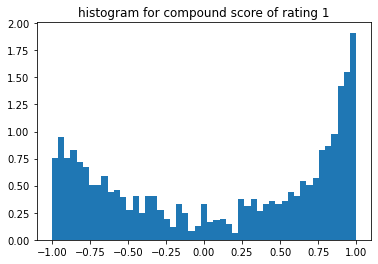

In [189]:
bins = np.linspace(-1, 1, 50)
plt.hist(data_new[data_new['Rating']==1]['Compound_Score'],bins, density=True)
plt.title("histogram for compound score of rating 1")
plt.show()

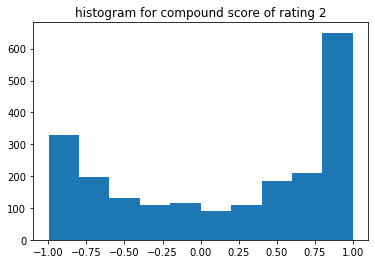

In [121]:
plt.hist(data[data['Rating']==2]['Compound_Score'])
plt.title("histogram for compound score of rating 2")
plt.show()

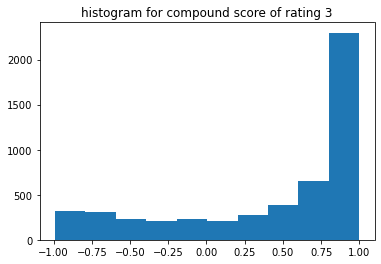

In [122]:
plt.hist(data[data['Rating']==3]['Compound_Score'])
plt.title("histogram for compound score of rating 3")
plt.show()

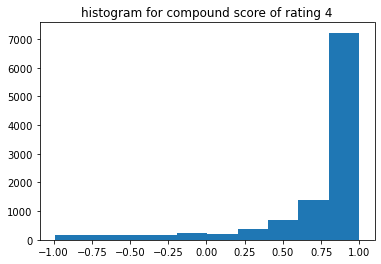

In [123]:
plt.hist(data[data['Rating']==4]['Compound_Score'])
plt.title("histogram for compound score of rating 4")
plt.show()

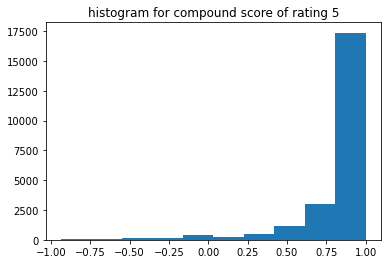

In [228]:
plt.hist(data_new[data_new['Rating']==5]['Compound_Score'])
plt.title("histogram for compound score of rating 5")
plt.show()

Look at the sample reviews from the top score in rating 1 and low score in rating 5

In [224]:
#length of the review
pd.options.display.max_colwidth = 2000

In [227]:
#A sample review from rating 1 with a score over 0.99
data_new[(data_new['Rating']==1)&(data_new['Compound_Score']>0.99)]['Review_Text'][12:13]

34230    I am writing this with a heavy heart having visited this attraction practically every year at Easter for the past 10 years. In fact, we were so disappointed by our experience this time that we probably won't be going back. WHY?With three kids, all under the age of 12, we go there for the rides. However, the following were all closed last week:Practically everything at FRONTIERLAND including:1. Big Thunder Mountain (Fastpass)2. Phantom Manor3. Thunder Mesa Riverboat Landing4. Pocahontas Indian VillageMost of ADVENTURELAND including:5. La Cabane des Robinson6. Pirates' Beach7. Adventure IsleAt FANTASYLAND:8. Peter Pan's Flight (Fastpass)And at DISCOVERYLAND:9. Star Wars (Fastpass)So of the 6 feature attractions (Fastpass), HALF OF THEM WERE CLOSED. And the total (9) equates to about a third of the park!And to compound this, with tickets for access to both parks, the Rock 'n' Roller Coaster (Faspass) at Walt Disney Studios were closed too! They do publish attractions that are clo

In [220]:
#A sample review from rating 5 with a score less than -0.9
data_new[(data_new['Rating']==5)&(data_new['Compound_Score']<-0.9)]['Review_Text'][2:3]

35726    Went for five days with the kids. Hate queuing. Hate paying over the odds. Hate marketing machines. Hate the poor food selections.Take a water bottle with you. Or buy a bottle. The refill for the rest of your stay at the drink fountains. We had a hot week and it was a godsend. Don't miss the closing ceremony or the parade: the smile on my kids faces bring tears to your eyes and make the who cost queuing worthwhile.Fabulous staff.
Name: Review_Text, dtype: object

Explore the distribution of the score in different branches

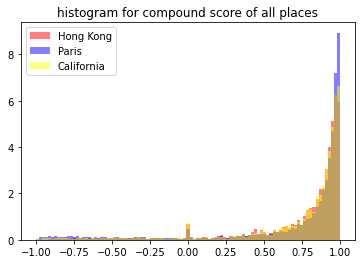

In [183]:
bins = np.linspace(-1, 1, 100)
plt.hist(data_new[data_new['Branch']=='Disneyland_HongKong']['Compound_Score'], bins,color = 'red', density=True, stacked=True, alpha=0.5, label='Hong Kong')
plt.hist(data_new[data_new['Branch']=='Disneyland_Paris']['Compound_Score'], bins,color = 'blue', density=True, stacked=True,alpha=0.5, label='Paris')
plt.hist(data_new[data_new['Branch']=='Disneyland_California']['Compound_Score'], bins,color = 'yellow', density=True, stacked=True,alpha=0.5, label='California')
plt.title("histogram for compound score of all places")
plt.legend(loc='upper left')
plt.show()